In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

In [ ]:
!pip install transformers evaluate datasets accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━

**Settings for reproducibility**

In [ ]:
seed = 0
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
torch.cuda.set_device(0)
device = torch.device("cuda")

**Unzip dataset folder**

In [ ]:
if not os.path.exists("/content/nlp"):
    !unzip "/content/gdrive/MyDrive/NLP (1)/nlp.zip"

Archive:  /content/gdrive/MyDrive/NLP (1)/nlp.zip
   creating: nlp/
  inflating: nlp/answers_students_test_data.tsv  
  inflating: nlp/answers_students_train_data.tsv  
  inflating: nlp/evalF1_no_penalty.pl  
  inflating: nlp/evalF1_penalty.pl   
  inflating: nlp/headlines_test_data.tsv  
  inflating: nlp/headlines_train_data.tsv  
  inflating: nlp/images_phrases_test_data.tsv  
  inflating: nlp/images_phrases_train_data.tsv  
  inflating: nlp/STSint.input.answers-students.wa  
  inflating: nlp/STSint.input.headlines.wa  
  inflating: nlp/STSint.input.images.wa  
  inflating: nlp/STSint.testinput.answers-students.wa  
  inflating: nlp/STSint.testinput.headlines.wa  
  inflating: nlp/STSint.testinput.images.wa  
  inflating: nlp/wellformed.pl       


**Choose model and get autotokenizer**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

#Load training and test datasets

In [ ]:
from datasets import load_dataset, concatenate_datasets
dataset_before = load_dataset("nlp", data_files={"train":["headlines_train_data.tsv", "images_phrases_train_data.tsv", "answers_students_train_data.tsv"],
                                                 "test":["headlines_test_data.tsv", "images_phrases_test_data.tsv", "answers_students_test_data.tsv"]}, quoting=3)

headlines_before = load_dataset("nlp", data_files={"train":"headlines_train_data.tsv", "test":"headlines_test_data.tsv"}, quoting=3)
images_before = load_dataset("nlp", data_files={"train":"images_phrases_train_data.tsv", "test":"images_phrases_test_data.tsv"}, quoting=3)
answers_before = load_dataset("nlp", data_files={"train":"answers_students_train_data.tsv", "test":"answers_students_test_data.tsv"}, quoting=3)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/nlp-b0458064ff40bb46/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/nlp-214c65b3313afb08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/nlp-1deb294b660f1015/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/nlp-972fcf33c408b3d2/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset_before['train'][0]

{'x1': 'at 91', 'x2': 'aged 91', 'y_type': 'EQUI', 'y_score': 5}

In [ ]:
dataset_before = dataset_before.shuffle(seed=seed)

#Tokenize and map the dateset

**Test tokenizer output**

In [ ]:
tokenizer(dataset_before["train"][0]["x1"])

{'input_ids': [0, 25784, 9632, 204, 8, 5, 1313, 9632, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
dataset_before["train"][0]

{'x1': 'between terminal 4 and the positive terminal',
 'x2': 'between terminal 4 and the positive terminal',
 'y_type': 'EQUI',
 'y_score': 5}

**Map y_score and y_type to classes in one hot format (best for CrossEntropyLoss)**

In [ ]:
import torch.nn.functional as F
types_map = {
    'EQUI': 7,
    'OPPO': 6,
    'SPE1': 5,
    'SPE2': 4,
    'SIMI': 3,
    'REL': 2,
    'ALIC': 1,
    'NOALI': 0,
}
def map_outputs(example):
  y_score = F.one_hot(torch.tensor(example["y_score"]), num_classes=6)
  y_type =  F.one_hot(torch.tensor(types_map[example["y_type"]]), num_classes=8)
  example['labels'] = torch.cat((y_score.view(-1), y_type.view(-1))).float()
  return example

In [ ]:
def map_none_outputs(example):
  example['x1'] = "" if isinstance(example['x1'], type(None)) else example['x1']
  example['x2'] = "" if isinstance(example['x2'], type(None)) else example['x2']
  return example

**Map and tokenize inputs**

In [ ]:
def tokenize_and_map(dataset):
    mapped_none_outputs = dataset.map(map_none_outputs)
    output_mapped_dataset = mapped_none_outputs.map( map_outputs, remove_columns=["y_type", "y_score"])
    return output_mapped_dataset.map(lambda example: tokenizer(example["x1"], example["x2"], truncation=True),
                                     batched=True, remove_columns=["x1", "x2"])

In [ ]:
dataset = tokenize_and_map(dataset_before)
headlines = tokenize_and_map(headlines_before)
images = tokenize_and_map(images_before)
answers = tokenize_and_map(answers_before)

Map:   0%|          | 0/10632 [00:00<?, ? examples/s]

Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Map:   0%|          | 0/10632 [00:00<?, ? examples/s]

Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Map:   0%|          | 0/10632 [00:00<?, ? examples/s]

Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Map:   0%|          | 0/3979 [00:00<?, ? examples/s]

Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/3979 [00:00<?, ? examples/s]

Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/3979 [00:00<?, ? examples/s]

Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/4805 [00:00<?, ? examples/s]

Map:   0%|          | 0/2462 [00:00<?, ? examples/s]

Map:   0%|          | 0/4805 [00:00<?, ? examples/s]

Map:   0%|          | 0/2462 [00:00<?, ? examples/s]

Map:   0%|          | 0/4805 [00:00<?, ? examples/s]

Map:   0%|          | 0/2462 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

**First six values of label are for y_score class, the rest for the y_type class**

In [ ]:
dataset['train'][0]

{'labels': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0],
 'input_ids': [0,
  25784,
  9632,
  204,
  8,
  5,
  1313,
  9632,
  2,
  2,
  25784,
  9632,
  204,
  8,
  5,
  1313,
  9632,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

#Train network

####Training params

In [ ]:
from transformers import TrainingArguments
import evaluate
batch_size = 16

args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01
)

####Define custom loss function

In [ ]:
from torch import nn
from transformers import Trainer

loss_fn = nn.CrossEntropyLoss()

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)

        logits = outputs.get("logits")

        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

####Evaluation metric

In [ ]:
metric = evaluate.load('f1');
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    return {'f1_score': metric.compute(predictions=predictions[:, :6].argmax(-1), references=labels[:, :6].argmax(-1), average="micro")['f1'],
            'f1_type':  metric.compute(predictions=predictions[:, 6:].argmax(-1), references=labels[:, 6:].argmax(-1), average="micro")['f1']}

####Get roberta model for sequence classification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=14)
model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

####Define trainer and train

In [ ]:
from transformers import Trainer
trainer = CustomTrainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Score,F1 Type
1,2.460300,2.183988,0.875749,0.843898


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1664 in train                    │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1945 in _inner_training_loop     │
│                                                                                                  │
│   1942 │   │   │   │   if (                                                                      │
│   1943 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│   1944 │   │   │   │   │   and not is_torch_tpu_available()                                      │
│ ❱ 1945 │   │   │   │   │   and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))          │
│   1946 │   │   │   │   ):                                                                        │
│   1947 │   │   │   │   │   # if loss is nan or inf simply add the average of previous logged lo  │
│   1948 │   │   │   │   │   tr_loss += tr_loss / (1 + self.state.global_step - self._globalstep_  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

**Load already trained model**

In [ ]:
# !unzip "/content/gdrive/MyDrive/NLP (1)/checkpoint-5985.zip"
model = AutoModelForSequenceClassification.from_pretrained("/content/checkpoint-5985", num_labels=14)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

**Save model**

In [ ]:
# !cp -r /content/roberta-large-finetuned/checkpoint-5985 /content/gdrive/MyDrive/NLP

####Evaluate on all datasets

In [ ]:
trainerHeadlines = CustomTrainer(
    model,
    args,
    train_dataset=headlines['train'],
    eval_dataset=headlines['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerHeadlines.evaluate()

{'eval_loss': 2.4670732021331787,
 'eval_f1_score': 0.8759803921568627,
 'eval_f1_type': 0.903921568627451,
 'eval_runtime': 7.1052,
 'eval_samples_per_second': 287.114,
 'eval_steps_per_second': 18.015}

In [ ]:
trainerImages = CustomTrainer(
    model,
    args,
    train_dataset=images['train'],
    eval_dataset=images['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerImages.evaluate()

{'eval_loss': 2.2203404903411865,
 'eval_f1_score': 0.9102355808285947,
 'eval_f1_type': 0.9187652315190902,
 'eval_runtime': 8.9831,
 'eval_samples_per_second': 274.069,
 'eval_steps_per_second': 17.143}

In [ ]:
trainerAnswers = CustomTrainer(
    model,
    args,
    train_dataset=answers['train'],
    eval_dataset=answers['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerAnswers.evaluate()

{'eval_loss': 2.099289655685425,
 'eval_f1_score': 0.9201086956521739,
 'eval_f1_type': 0.9402173913043478,
 'eval_runtime': 8.4968,
 'eval_samples_per_second': 216.551,
 'eval_steps_per_second': 13.534}

####Function for calculating predictions

In [ ]:
def pr_re(trainer):
  eval_dataloader = trainer.get_eval_dataloader()
  score_preds = torch.empty((0), dtype=torch.int64).to(device)
  score_refs = torch.empty((0), dtype=torch.int64).to(device)

  type_preds = torch.empty((0), dtype=torch.int64).to(device)
  type_refs = torch.empty((0), dtype=torch.int64).to(device)
  model.eval()
  for batch in eval_dataloader:
      labels = batch["labels"].to(device)
      batch = {k: v.to(device) for k, v in batch.items()}

      with torch.no_grad():
          outputs = model(**batch)
      outputs = outputs.logits

      score_preds = torch.cat((score_preds, outputs[:, :6].argmax(-1)), dim=0)
      score_refs = torch.cat((score_refs, labels[:, :6].argmax(-1)), dim=0)

      type_preds = torch.cat((type_preds, outputs[:, 6:].argmax(-1)), dim=0)
      type_refs = torch.cat((type_refs, labels[:, 6:].argmax(-1)), dim=0)
  return score_preds,score_refs,type_preds,type_refs

In [ ]:
nameToDataset = {'images': trainerImages, 'answers-students':trainerAnswers, 'headlines':trainerHeadlines }
namesList = ['images', 'answers-students', 'headlines']

In [ ]:
metric = evaluate.load('glue', 'stsb')
for name in namesList:
  score_preds, score_refs, type_preds, type_refs = pr_re(nameToDataset[name])
  print(f"{name}: {metric.compute(predictions=score_preds, references=score_refs)}")

images: {'pearson': 0.985924388437507, 'spearmanr': 0.9871417264483148}
answers-students: {'pearson': 0.987334104173131, 'spearmanr': 0.9869709449883107}
headlines: {'pearson': 0.9826921199138309, 'spearmanr': 0.9797513111955198}


####Function for displaying confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def img(score_preds,score_refs,type_preds,type_refs, name):
  cf_matrix = confusion_matrix(score_refs.cpu(), score_preds.cpu(), labels=[0, 1, 2, 3, 4,5])
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.title(name+" Score")
  plt.xlabel("Predicted Labels")
  plt.ylabel("Real Labels")
  # Build type confusion matrix
  cf_matrix = confusion_matrix(type_refs.cpu(), type_preds.cpu(), labels=[0, 1, 2, 3, 4,5,6,7])
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.title(name+" Type")
  plt.xlabel("Predicted Labels")
  plt.ylabel("Real Labels")

####Display confusion matrix for all datasets

<ipython-input-38-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in true_divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-38-41c1e3dcb084>:8: RuntimeWarning: invalid value encountered in true_divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-38-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in true_divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-38-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in true_divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])


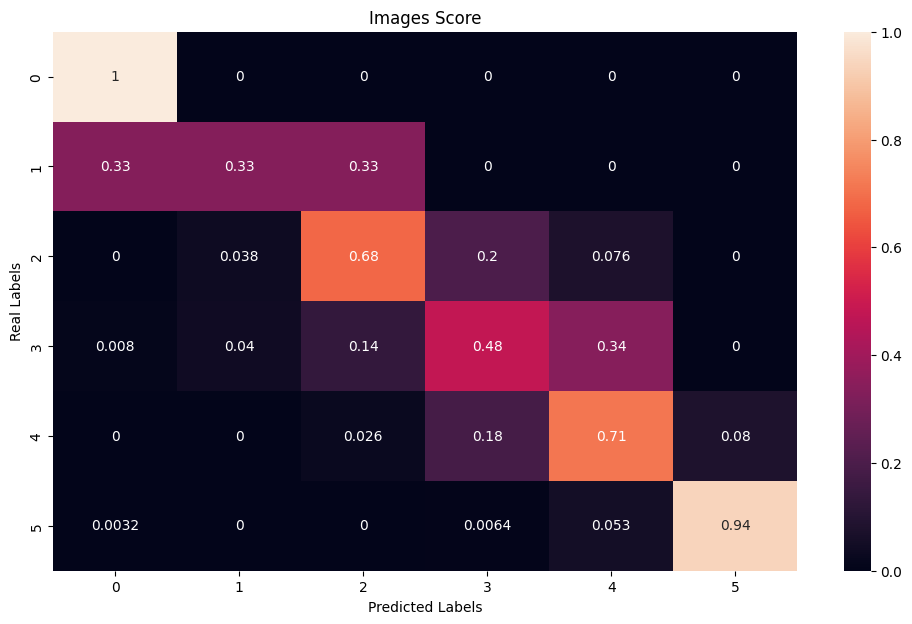

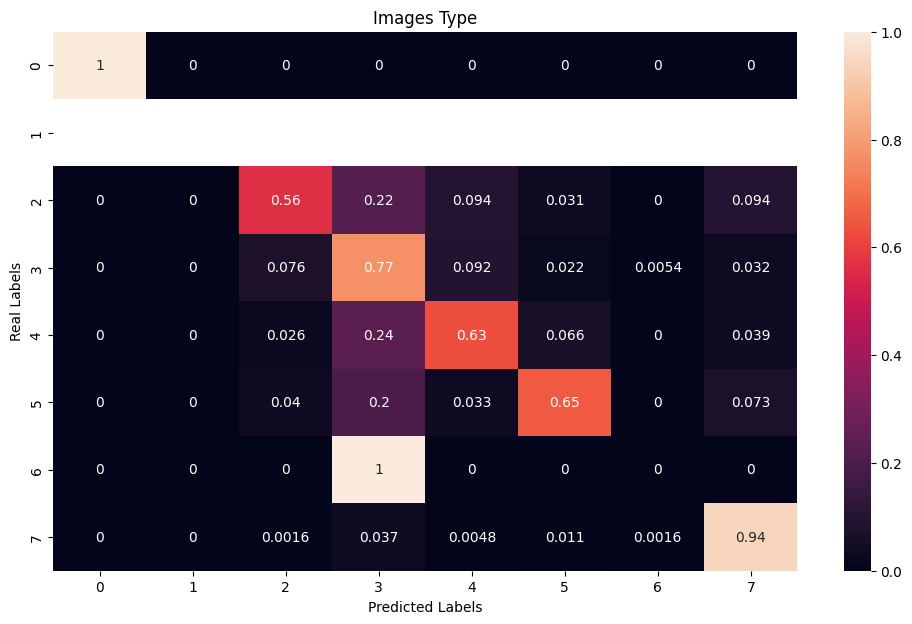

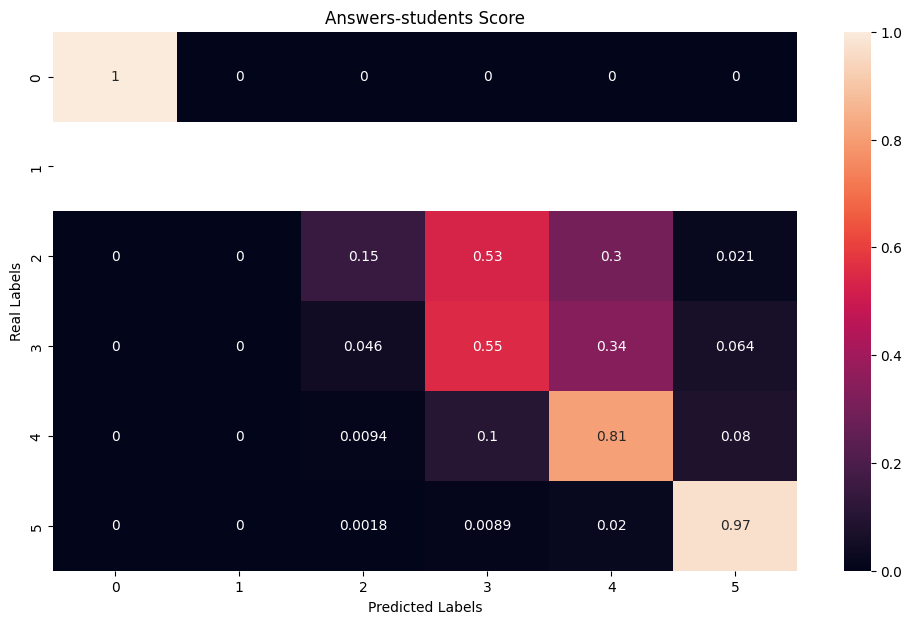

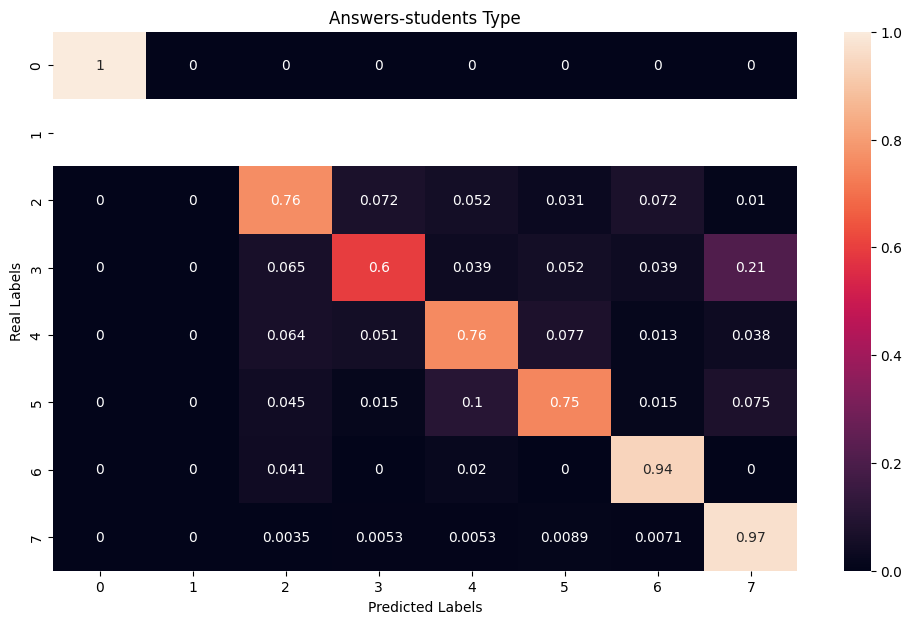

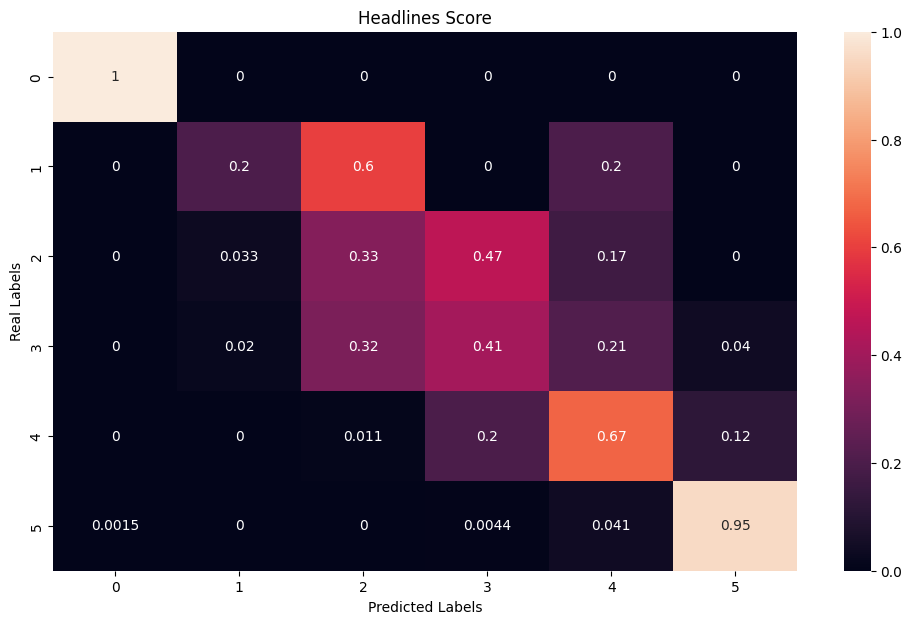

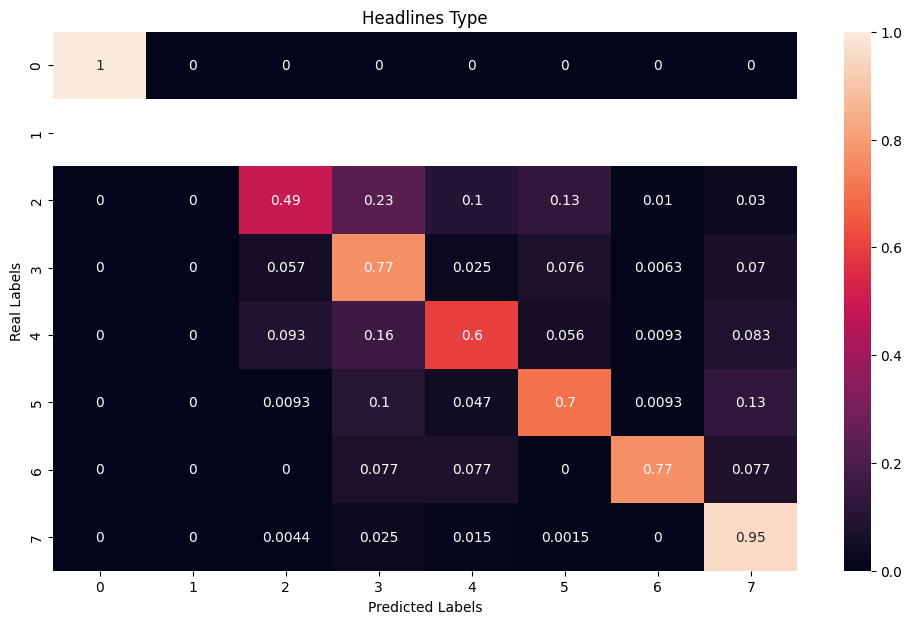

In [ ]:
for name in namesList:
  score_preds,score_refs,type_preds,type_refs = pr_re(nameToDataset[name])
  img(score_preds,score_refs,type_preds,type_refs,name.capitalize())

####Functions for calculatating F1 metrics from file

In [ ]:
fields_sep = ' // '

def preds_to_wa(wa_content, preds_lines):
    wa_lines = wa_content.splitlines()

    idx = 0
    result = []

    for line in wa_lines:
        line_res = line

        if '<==>' in line :
            fields = line.split(fields_sep)
            preds_fields = preds_lines[idx].split()

            fields[1] = preds_fields[1]
            fields[2] = preds_fields[2]

            line_res = fields_sep.join(fields)
            idx += 1
        result.append(line_res)
    return '\n'.join(result)

In [ ]:
from subprocess import check_output
def fileF(DATASET,predictions):
  wa_file = os.path.join(f"/content/nlp/STSint.testinput.{DATASET}.wa")
  wa_output_file = os.path.join(f"/content/nlp/STSint.input.{DATASET}-predictions.wa")

  with open(wa_file) as file:
      wa_test = file.read()

  wa_predictions = preds_to_wa(wa_test, predictions)

  with open(wa_output_file, "w") as file:
      file.write(wa_predictions)

  cmds = [
      f"perl evalF1_penalty.pl {wa_file} {wa_output_file}",
      f"perl evalF1_no_penalty.pl {wa_file} {wa_output_file}",
  ]
  outputs = []
  for cmd in cmds:
    print(f"Executing {cmd}")
    output = check_output(cmd.split(), cwd="/content/nlp").decode()
    outputs.append(output)
    print(output)
  return outputs

In [ ]:
types_d = {number: Type for Type, number in types_map.items()}
def to_str(llist):
  nl = []
  for i in llist:
    nl.append(types_d[i])
  return nl

####Calculate f1 metrics from evalF1 file

In [ ]:
for name in namesList:
  score_preds, score_refs, type_preds, type_refs = pr_re(nameToDataset[name])
  types = to_str(type_preds.tolist())
  scores = score_preds.tolist()
  predictions = [
      f"{index}\t{Type} {score}\n" for index, (Type, score) in enumerate(zip(types, scores))
  ]
  fileF(name, predictions)

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.images.wa /content/nlp/STSint.input.images-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8104
 F1 Score   0.9569
 F1 Typ+Sco 0.8417

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.images.wa /content/nlp/STSint.input.images-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8104
 F1 Score   0.9569
 F1 Typ+Sco 0.7917

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.answers-students.wa /content/nlp/STSint.input.answers-students-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8864
 F1 Score   0.9629
 F1 Typ+Sco 0.8877

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.answers-students.wa /content/nlp/STSint.input.answers-students-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8864
 F1 Score   0.9629
 F1 Typ+Sco 0.8679

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.headlines.wa /content/nlp/STSint.input.headlines-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.81